# Test the Methods from the RetinaNet network
## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

from datasets.coco import COCODetection
from cfgs.config import config

import torch
from torch.utils.data import DataLoader

from models import retina
from utils.logger import load_checkpoints
from lib.det_ops.anchors import generate_anchors, compute_anchor_whs
from lib.bbox import bbox, box_transform
from lib.nms import nms
#import bbox_transform, bbox_transform_inv

%matplotlib inline

/home/ganswindt/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Test the Image Import

In [2]:
cfg = config['coco_baseline']
ds = COCODetection(dataroot=cfg['data_dir'], imageset='train', config=cfg, training=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


(1608, 1608, 3)

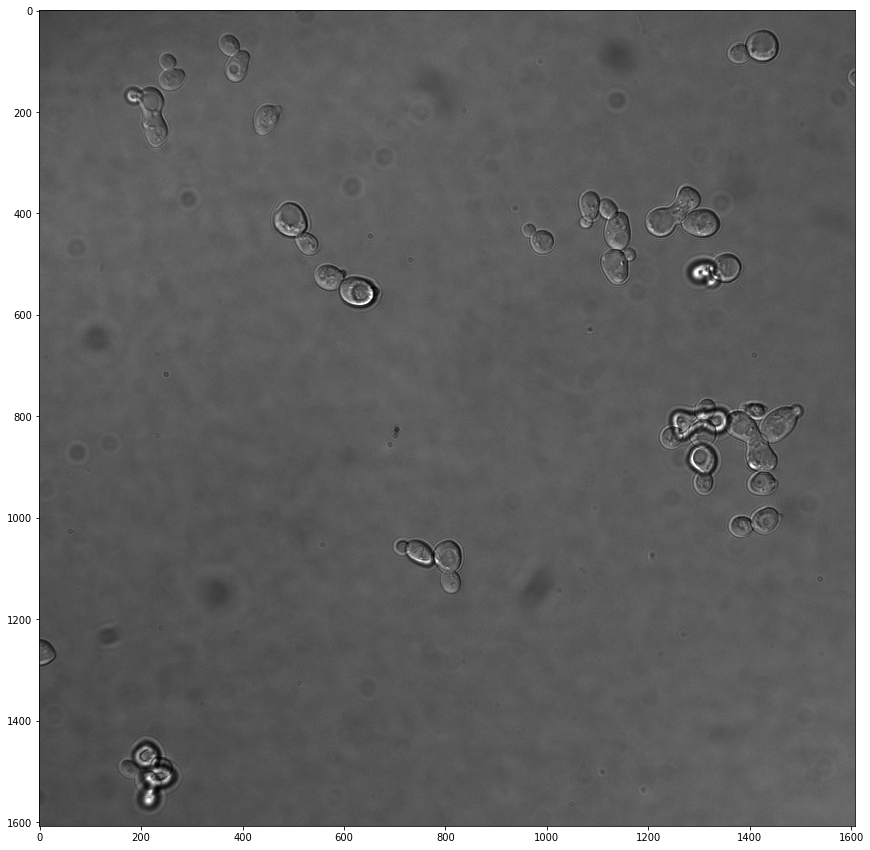

In [3]:
img, cls, box = ds[0]


plt.figure(figsize=(15,15))
plt.imshow(img[:,:,0], cmap='gray')

img.shape

## Test the Tensorboard and Normalization

In [4]:
import tensorboardX
import torch.tensor as tt
import torch
import torch.nn as nn
from datasets import minibatch

writer = tensorboardX.SummaryWriter('/scratch/ganswindt/test_retinanet/1306_1')

dl = DataLoader(ds, batch_size=1, num_workers=1, collate_fn=minibatch.create_minibatch_func(cfg), shuffle=False)
img, cls, box, anchorboxs = next(iter(dl))



img = img / img.max()

writer.add_image('daimg', img[0], 0 )
writer.add_image_with_boxes('daimg with BBox', img[0], anchorboxs[0][cls[0]>0], 0)


def white(img):
    return (img - np.mean(img))/np.std(img)

print(len(anchorboxs[0][cls[0]>0]))


38


In [5]:
ds.coco_helper.imgs

{72: {'id': 72,
  'file_name': 'Cells_72.tiff',
  'width': 1608,
  'height': 1608,
  'date_captured': '2019-06-07 13:47:24.096118',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 21: {'id': 21,
  'file_name': 'Cells_21.tiff',
  'width': 1608,
  'height': 1608,
  'date_captured': '2019-06-07 13:47:24.096118',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 9: {'id': 9,
  'file_name': 'Cells_9.tiff',
  'width': 1608,
  'height': 1608,
  'date_captured': '2019-06-07 13:47:24.096118',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 37: {'id': 37,
  'file_name': 'Cells_37.tiff',
  'width': 1608,
  'height': 1608,
  'date_captured': '2019-06-07 13:47:24.096118',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 51: {'id': 51,
  'file_name': 'Cells_51.tiff',
  'width': 1608,
  'height': 1608,
  'date_captured': '2019-06-07 13:47:24.096118',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 76: {'id': 76,
  'file_name': 'Cells_76.tiff',
  'width': 1608,
  '

## Draw ground-truth BBoxes 

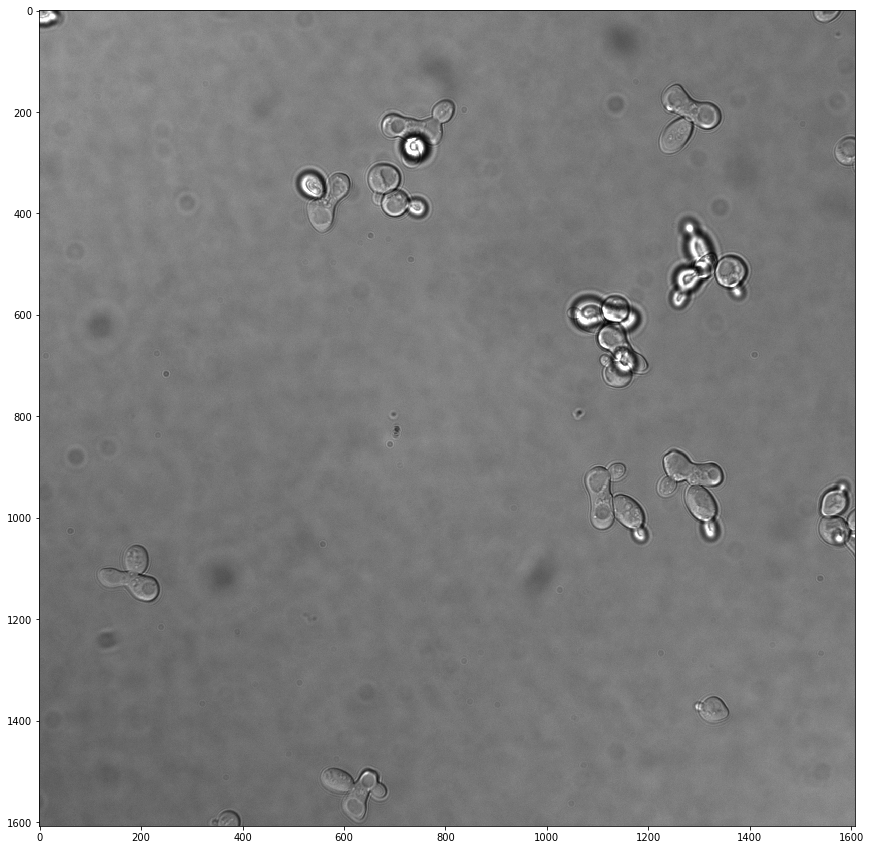

In [6]:
import json
from skimage.external.tifffile import imread
import os
from matplotlib.patches import Rectangle

img_id = 37
img_path = '/scratch/ganswindt/retinanet/COCO/DIR/images/train/Cells_{}.tiff'.format(img_id)
annot = '/scratch/ganswindt/retinanet/COCO/DIR/annotations/instances_train.json'

with open(annot, 'r' ) as fd:
    annot = json.load(fd)
    
img = imread(img_path)
img = img / np.max(img)

plt.figure(figsize=(15,15))
plt.imshow(img, cmap='gray')

for a in [a for a in annot['annotations'] if a['image_id']==str(img_id)]:
    x1, y1, w, h = a['bbox']
    r = Rectangle([x1, y1], w, h, fill=None, color='red')
    plt.gca().add_artist(r)
plt.show()

## Check the methods from test.py

In [2]:
cfg = config['coco_baseline']
ds = COCODetection(dataroot=cfg['data_dir'], imageset='val', config=cfg, training=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
model_path = '/scratch/ganswindt/retinanet/log_1306/coco_baseline/model_dump/epoch-9999-iter-180000.pth'

anchor_scales = cfg['anchor_sizes']
anchor_apsect_ratios = cfg['aspect_ratios']
num_anchors = len(anchor_scales) * len(anchor_apsect_ratios)

model = retina.RetinaNet(cfg['num_classes']-1, num_anchors, cfg['basemodel_path']).cuda()
state_dict, _, _, _ = load_checkpoints(model_path)
model.load_state_dict(state_dict)

model.eval()

results = dict()

for imidx in range(8):
    img, imid, scale, im_size = ds[imidx]

    
    img = img.cuda()

    cls_pred, bbox_pred = model(img.unsqueeze(0))
    scores = cls_pred.sigmoid()#.squeeze()

    anchor_whs = compute_anchor_whs(len(cfg['strides']), areas=cfg['anchor_areas'],
                                        aspect_ratios=anchor_apsect_ratios,
                                        sizes=anchor_scales)
    h_, w_ = img.shape[1], img.shape[2]
    anchors = generate_anchors(anchor_whs, input_size=np.array([h_, w_]),
                                           strides=cfg['strides'])
    boxes = box_transform.bbox_transform_inv(anchors.cuda(), bbox_pred.squeeze())
    boxes = bbox.clip_boxes(boxes, im_size[0], im_size[1])

    result_boxes = []
    scores= scores.squeeze()
    max_labels = torch.argmax(scores, dim=1)

    for cls in range(cfg['num_classes']-1):

        # filter predictions through 'classification threshold'
        score = scores[:, cls]
        cls_inds = score > cfg['cls_thresh']
        # current class has the max score over all classes
        max_inds = max_labels == cls
        cls_inds = max_inds * cls_inds
        if cls_inds.sum() < 1:
            continue
        # score [K]
        score = score[cls_inds]

        # _boxes [K, 4]
        _boxes = boxes[cls_inds]

        # NMS remove duplicate
        keep = nms(torch.cat([_boxes, score.unsqueeze(1)], 1), cfg['test_nms'])

        score = score[keep]
        _boxes = _boxes[keep]

        

        for i in range(_boxes.shape[0]):
            result_boxes.append((cls, score[i].item(), _boxes[i].cpu().data.numpy().tolist()))

        # Keep Max Num Boxes
        if len(result_boxes) > cfg['test_max_boxes']:
            result_boxes = sorted(result_boxes, key=lambda x: x[1], reverse=True)
            result_boxes = result_boxes[:cfg['test_max_boxes']]
        
        if len(result_boxes) == 0:
            continue

        result_img = dict()
        tmp = []

        for i in range(len(result_boxes)):
            cls, s, b, = result_boxes[i]

            pred = dict()
            
            b = [float(box) for box in b]

            pred['score'] = s
            pred['category_id'] = cls + 1
            pred['bbox'] = b
            
            if imid in results:
                results[imid].append(pred)
            else:
                tmp.append(pred)
                results[imid] = tmp


In [4]:
print(len(results))

8


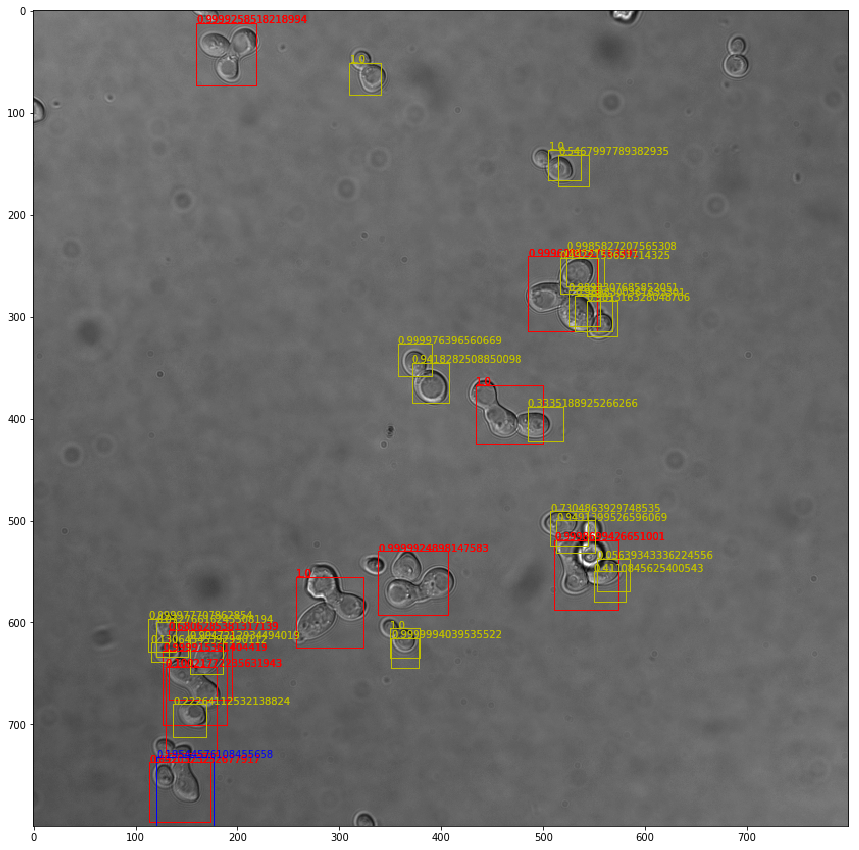

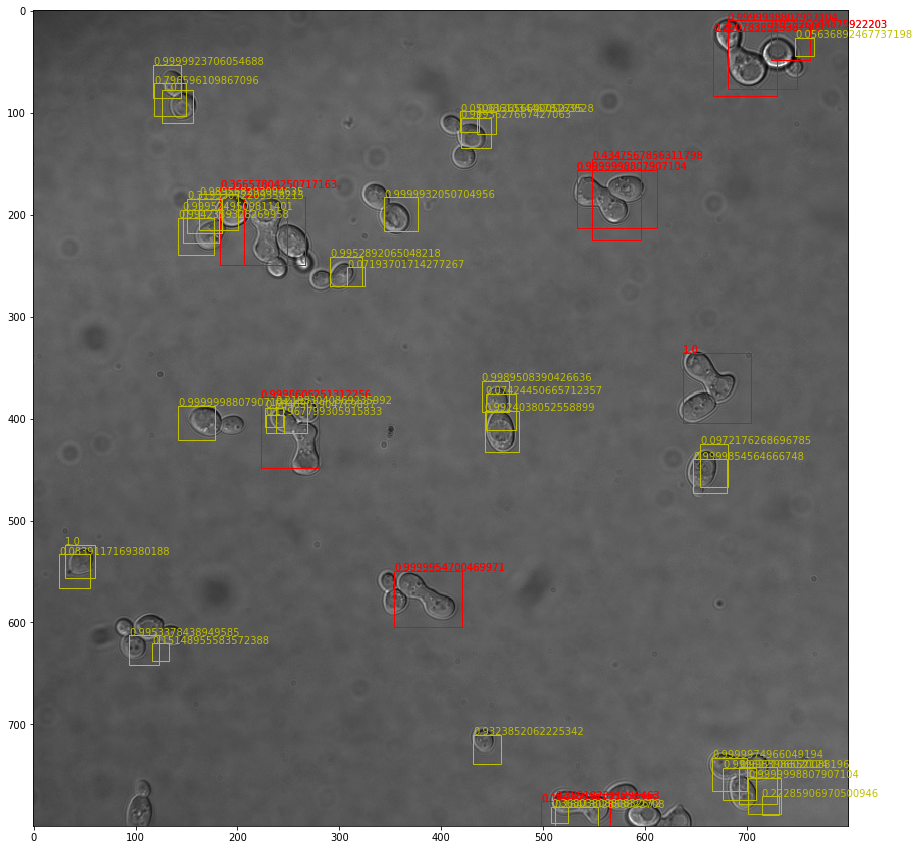

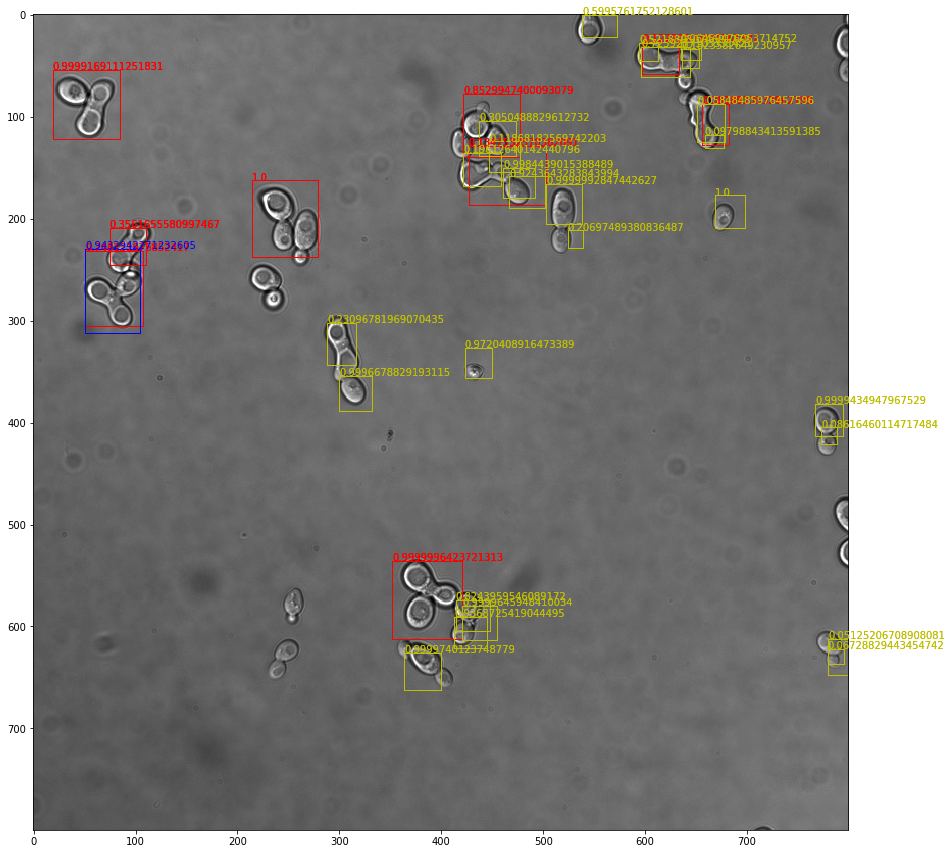

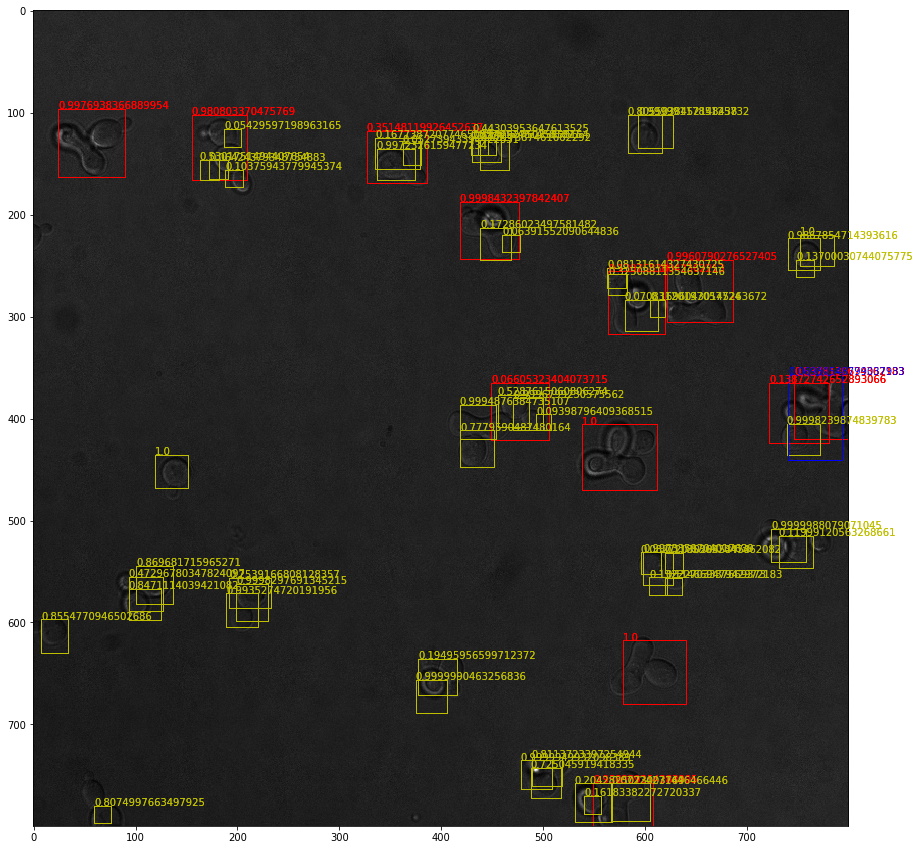

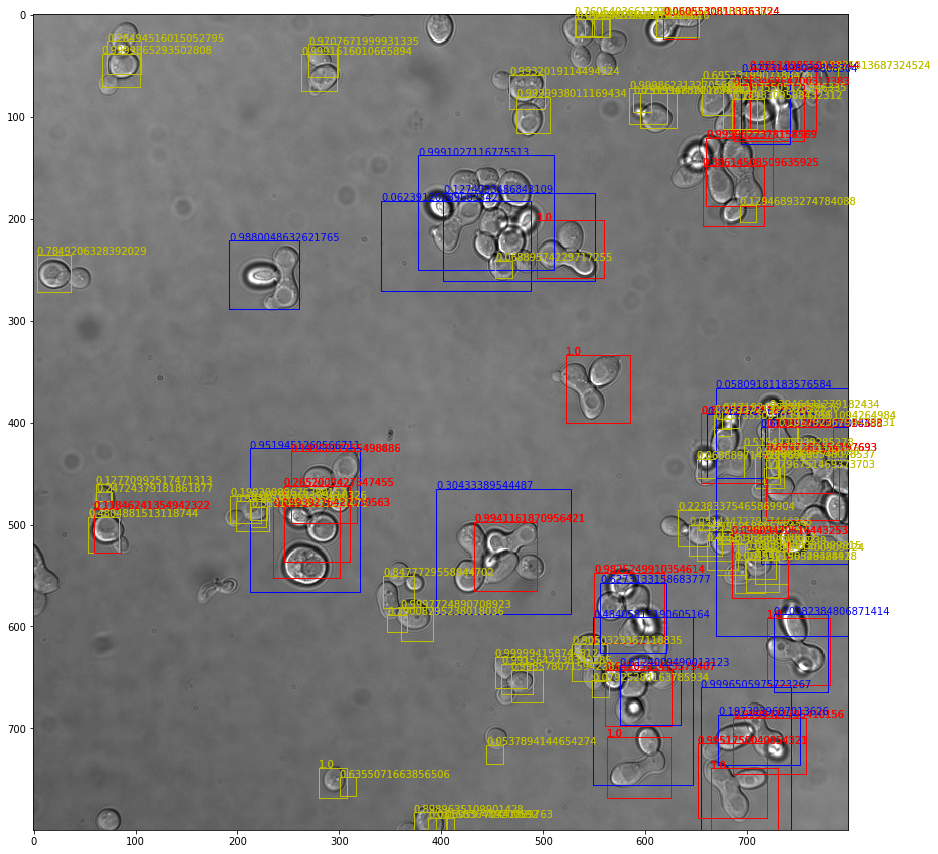

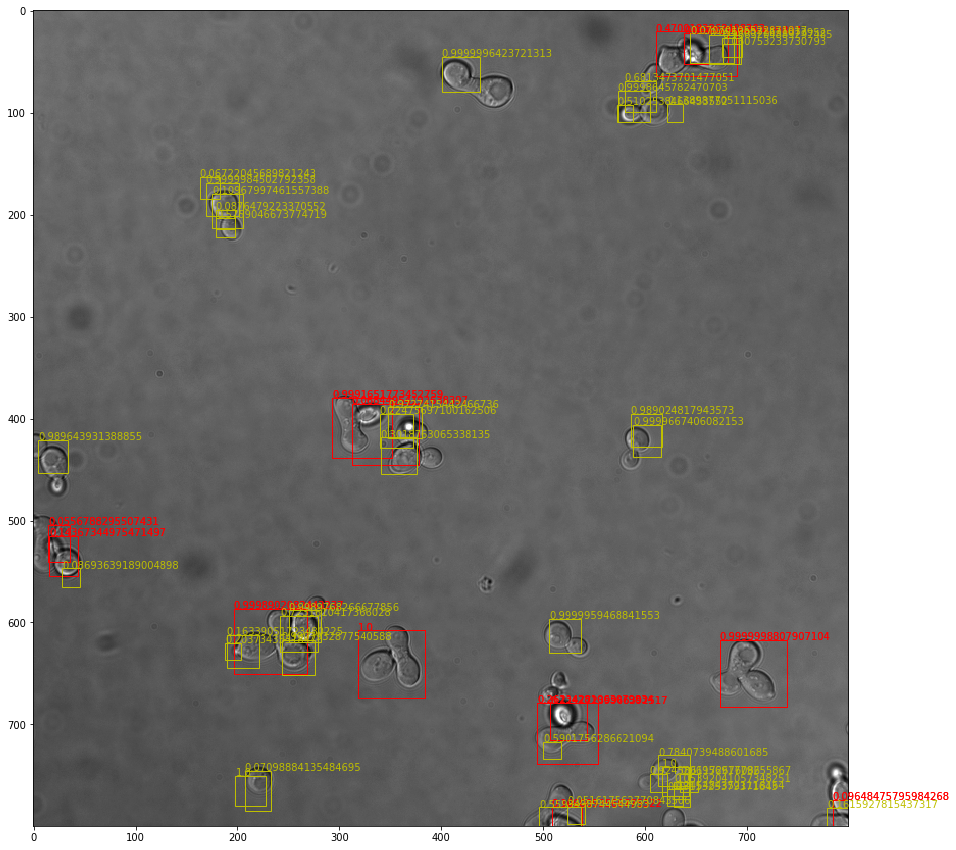

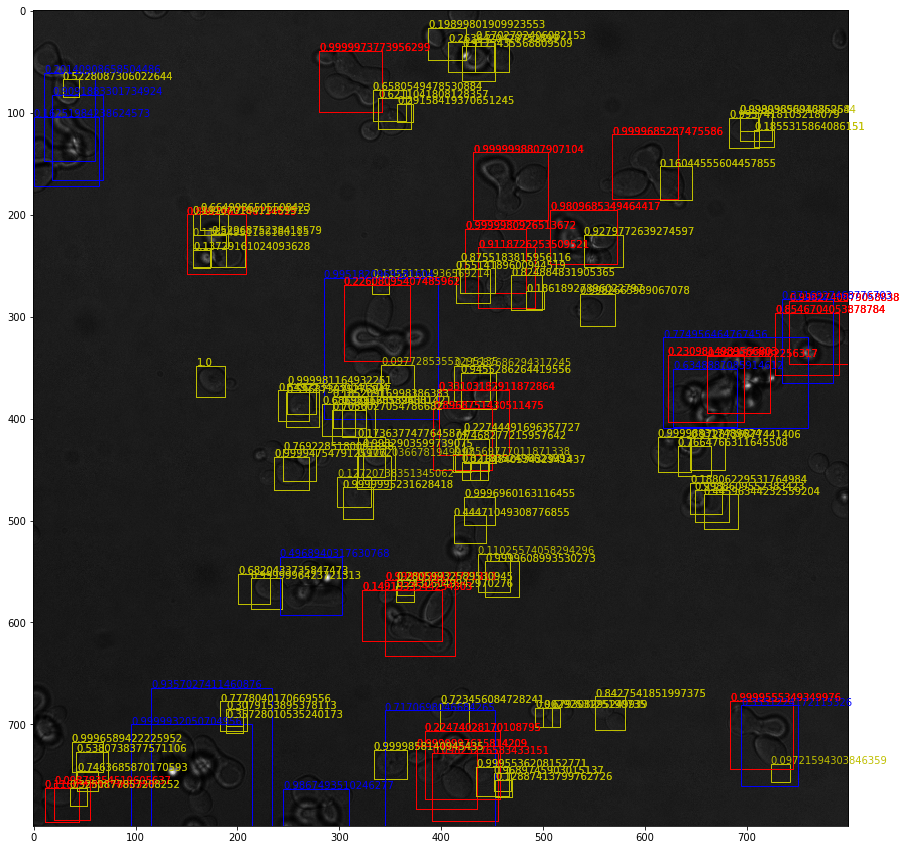

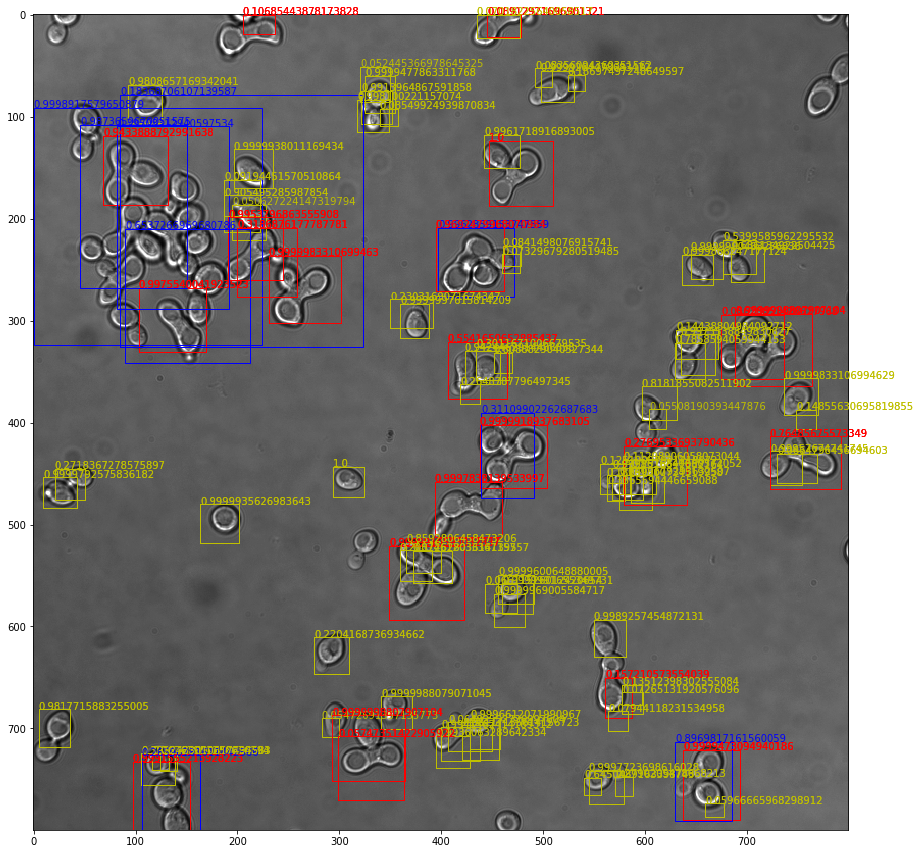

In [5]:
for imidx in range(8):
    #print(imidx)
    img, imid, scale, (h,w) = ds[imidx]
    
    #print(imid)
    
    img = img.cuda()
    
    plt.figure(figsize=(15,15))
    plt.imshow(img.cpu().detach().numpy()[0], cmap='gray')

    boxes_img = results[imid]
    #bx = boxes_img.cpu().detach().numpy()
    for i in boxes_img:
        bxi = i['bbox']
        #print(bxi)
        wi = bxi[2] - bxi[0]
        hi = bxi[3] - bxi[1]
        rec = Rectangle(bxi[:2], wi, hi, color=[None, 'r', 'y', 'b'][i['category_id']], fill=None)
        plt.gca().add_artist(rec)
        plt.text(*bxi[:2], str(i['score']), color=[None, 'r', 'y', 'b'][i['category_id']])    